In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from sklearn.decomposition import PCA

In [94]:
def load_data():
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.view(-1))])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    x_train_raw = train_dataset.data.numpy()
    x_test_raw = test_dataset.data.numpy()

    # Flatten to a 2D array where each row is a pixel (28*28 = 784 pixels) for a given image
    x_train_reshaped = x_train_raw.reshape(-1, 784)
    x_test_reshaped = x_test_raw.reshape(-1, 784) 

    # Normalize data between 0 and 1 (For Sigmoid & PCA later on)
    x_train_normalized = x_train_reshaped / 255.0
    x_test_normalized = x_test_reshaped / 255.0 

    # Convert to tensor
    x_train_tensor = torch.tensor(x_train_normalized, dtype=torch.float32), 
    x_test_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)

    return x_train_tensor[0], x_test_tensor[0]

X_train, _ = load_data()
X_train = X_train[:60_000, ]

# Create DataLoaders for batch processing
train_loader = DataLoader(TensorDataset(X_train), batch_size=64, shuffle=True)

In [95]:
class Autoencoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),  # N, 784 -> N, 512
            nn.ReLU(), 
            nn.Linear(512, 256),
            nn.ReLU(), 
            nn.Linear(256, 128)  # N, 256 -> N, 128
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 256),  # N, 128 -> N, 256
            nn.ReLU(), 
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()  # N, 128 -> N, 784
        )

    def forward(self, X): 
        latent = self.encoder(X)
        reconstructed = self.decoder(latent)

        return reconstructed, latent

In [96]:
# Training loop parameters
num_epochs = 20
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [97]:
train_loss_per_epoch = []
latent_codes = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    
    for batch in train_loader:
        inputs, = batch  # Unpack the batch (DataLoader returns a tuple)
        
        # Forward pass to get the reconstructed output and latent codes
        reconstructed, latent = model(inputs)
        latent_codes.append(latent)
        
        # Calculate the loss
        loss = criterion(reconstructed, inputs)  # MSE between reconstructed output and input
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() 
        
    # Average loss over all samples
    train_loss_per_epoch.append(train_loss)
    #train_loss /= len(train_loader.dataset)

    print(train_loss)

6.584179788827896
4.570700421929359
3.3395502604544163
2.6808859165757895
2.3684538286179304
2.087983913719654
1.874803103506565
1.7133890949189663
1.5747767742723227
1.4573803022503853
1.3660861682146788
1.282781315036118
1.197309646755457
1.1255269022658467
1.0689860256388783
1.0215717321261764
0.9820034392178059
0.9334981981664896
0.9072871748358011
0.8662936454638839


In [98]:
def preprocess_latent_codes(latent_codes):
    # Concatenate the list of tensors into a single tensor along the first dimension
    latent_tensor = torch.cat(latent_codes, dim=0)
    # Convert the tensor to a NumPy array
    return latent_tensor.detach().cpu().numpy()

processed_latent_codes = preprocess_latent_codes(latent_codes)

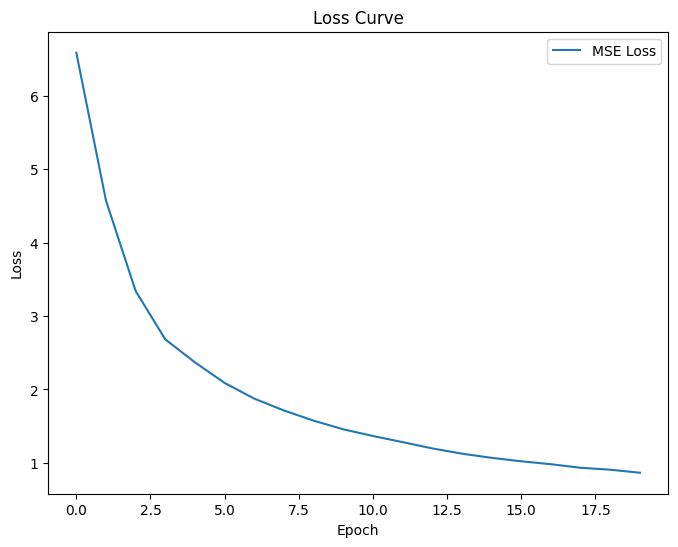

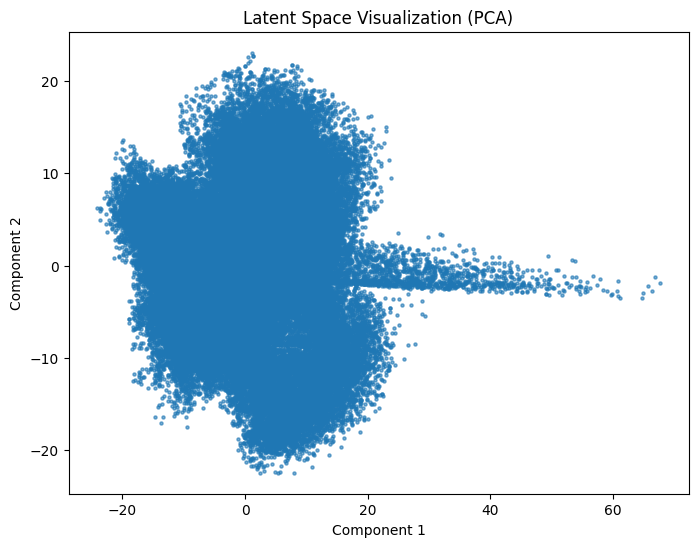

In [99]:
# 8. Plot the loss curve
def plot_loss_curve(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# Uncomment after training to plot the loss curve
plot_loss_curve(train_loss_per_epoch)

# 9. Visualize latent codes using PCA
def visualize_latent_space(latent_codes):
    pca = PCA(n_components=2)
    reduced_codes = pca.fit_transform(latent_codes)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_codes[:, 0], reduced_codes[:, 1], s=5, alpha=0.6)
    plt.title('Latent Space Visualization (PCA)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Uncomment after training to visualize latent space
visualize_latent_space(processed_latent_codes)

# 10. Show original and reconstructed images side by side
def show_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Uncomment after training to show images
# show_images(x_train, reconstructed_data)